# Anomalías en Mapas

Hasta ahora hemos visto diferentes maneras de ver anomalías, pero digamos que son puntuales, es decir una serie de tiempo única.

Es momento de que comencemos a trabajar con anomalías en matrices, y así, poder hacer representaciones en mapas.

In [1]:
pip install netCDF4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 32.1 MB/s eta 0:00:00


In [2]:
pip install cartopy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 20.3 MB/s eta 0:00:00


In [3]:
# Librerías
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import netCDF4
from netCDF4 import num2date
import datetime
import matplotlib as mpl


Si se dan cuenta, hay una librería que les mencionaron pero no la hemos explorado, se llama netCDF4 y así como xarray, sirve para manipular archivos netCDF.

Ahora usaremos un poco netCDF4 para qué vean cómo se usa pero, y de acuerdo con ChatGPT:  "*si solo necesitas leer o manipular archivos netCDF a un nivel muy básico o con un control muy detallado, netCDF4 puede ser adecuado. Pero si estás realizando análisis complejos y trabajas regularmente con datos multidimensionales, xarray ofrece una interfaz más rica y fácil de usar que puede mejorar significativamente la eficiencia y claridad de tu código*."

Utilicen la librería con la que se sientan más cómod@s.

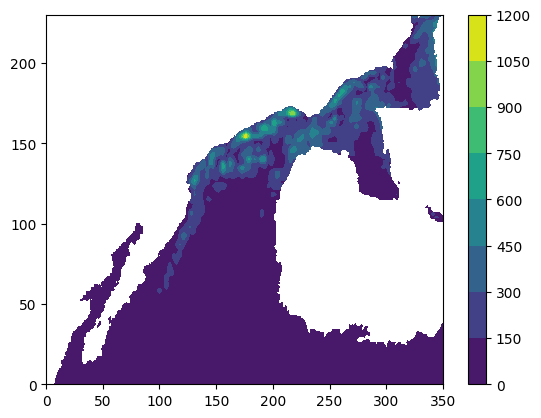

In [4]:
# *.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.

# Leer los datos

# Por comodidad a mi me gusta poner la ruta aparte y luego cargar los datos pero como ustedes gusten

ruta = '/content/Mexico_ppt.nc'
dataset  = netCDF4.Dataset(ruta) # Aqui se lee el archivo con la librería netCDF4
# Y es en esa variable donde vamos a poder la información del netCDF

# De preferencia lean sus datos de esta manera y les diré por qué
times = num2date(dataset.variables['time'][:], dataset.variables['time'].units, calendar = 'standard')

# Así es como se leen las variables con esta librería
lon = dataset.variables['longitude'][:]
lat = dataset.variables['latitude'][:]
data = dataset.variables['tp'][:,:,:] # Analicemos esto


# Tenemos que convertir nuestros datos
data = (30.436875*1000)*data

# Recomendación: Hagan un plot rápido para ver sus datos
plt.contourf(data[5,:,:]);plt.colorbar()


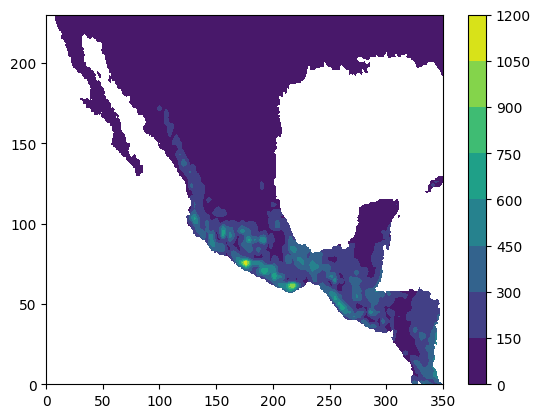

In [5]:
# Si se dan cuenta, hay algo extraño, entonces hay que enderezar los datos
plt.contourf(np.flipud(data[5,:,:]));plt.colorbar()

Afortunadamente con Cartopy no hay que mover nada de nuestros datos. Pero hay otras librerías como Basepam que sí tienen que tener esto en cuenta.

In [6]:
# Vamos a obtener nuestra primer anomalía
# Pero qué necesitamos? Necesitamos el valor de referencia y un valor
# que queremos ver si es anómalo o no

# El periodo de referencia que vamos a tomar va a ser 1991 - 2001
# Tenemos que seleccionar los datos que corresponden a ese rango de fechas

date1 = datetime.datetime(1991,1,1,0,0)
date2 = datetime.datetime(2001,12,1,0,0)

start_index = (np.abs(times - date1)).argmin()
end_index = (np.abs(times - date2)).argmin()

print(start_index, end_index)

ind = []

for idx, month in enumerate(times):
  if (month>=date1 and month<=date2):
      ind.append(idx)

historic_data = data[ind, :, :]

12 143


In [7]:
# Muy bien entonces, tenemos un array con todos los meses de todos los años desde
# 1990 a 2001.
# Ahora hay que tomar nuestro valor de referencia o sea el promedio

base = np.mean(historic_data, axis = 0)
base.shape
# Esto va a dar una matriz

(231, 351)

In [8]:
# Ahora hay que buscar qué queremos comparar supongamos que queremos analizar el
# año 2020

date1 = datetime.datetime(2020,1,1,0,0)
date2 = datetime.datetime(2020,12,1,0,0)

ind_act = []
for idx, month in enumerate(times):
    if (month >= date1 and month <= date2):
        ind_act.append(idx)


act_yr = data[ind_act, :, :]


In [9]:
# Ahora hay que tomar el promedio anual

prom_act = np.mean(act_yr, axis = 0)

# Ya que tenemos matrices del mismo tamaño entonces sí se puede
# obtener la anomalía


anom = prom_act - base

Text(0.5, 1.0, 'Anomalía de precipitación del Año: 2020')

/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


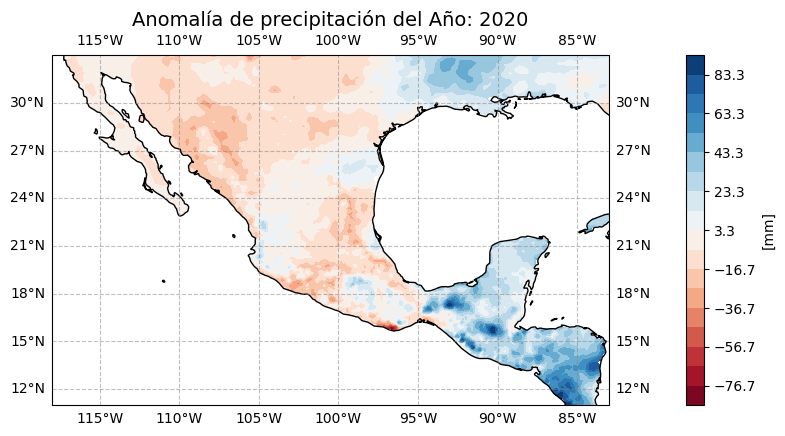

In [10]:
# Entonces vamos a plotear usando cartopy

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(2, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([-118,-83, 11, 33], crs=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels = True, dms = True, x_inline = False, y_inline = False, color = 'gray', alpha = 0.5, linestyle='--')
cs = ax.contourf(lon, lat, anom, levels = np.arange(np.min(anom), np.max(anom), 10), cmap = 'RdBu', transform=ccrs.PlateCarree())
plt.colorbar(cs, pad = 0.1, label = '[mm]')
plt.title('Anomalía de precipitación del Año: 2020', fontsize = 14)

Text(0.5, 1.0, 'Anomalía de precipitación del Año: 2020')

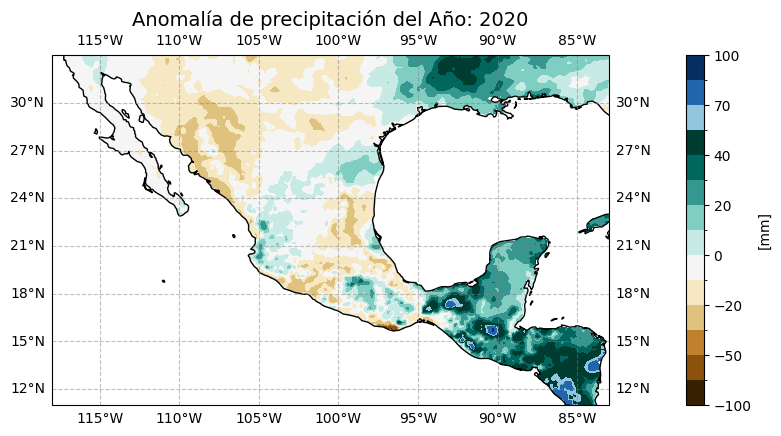

In [11]:
# Pueden también hacer sus propias barras de color

bounds = [-100,-80,-50,-40,-20,-10,0,10,20,30,40,60,70,90,100]
colors = ['#372001','#8C510B','#BF812E','#DFC27E','#F6E8C3','#F5F5F5','#C7EAE4','#80CEC1','#369790','#01665E','#003C30','#92C6DE','#2165AC','#063062']

# crear la rampa en donde a partir del cero los colores divergen
my_map = mpl.colors.ListedColormap(colors)
norm = mpl.colors.BoundaryNorm(bounds, my_map.N)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(2, 1, 1, projection=ccrs.PlateCarree())
# Extención del mapa
ax.set_extent([-118,-83, 11, 33], crs=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels = True, dms = True, x_inline = False, y_inline = False, color = 'gray', alpha = 0.5, linestyle='--')
cs = ax.contourf(lon, lat, anom, levels = bounds, cmap = my_map, norm = norm,  transform=ccrs.PlateCarree())
plt.colorbar(cs, pad = 0.1, label = '[mm]')
plt.title('Anomalía de precipitación del Año: 2020', fontsize = 14)


Text(0.5, 1.0, 'Anomalía de precipitación del Año: 2020')

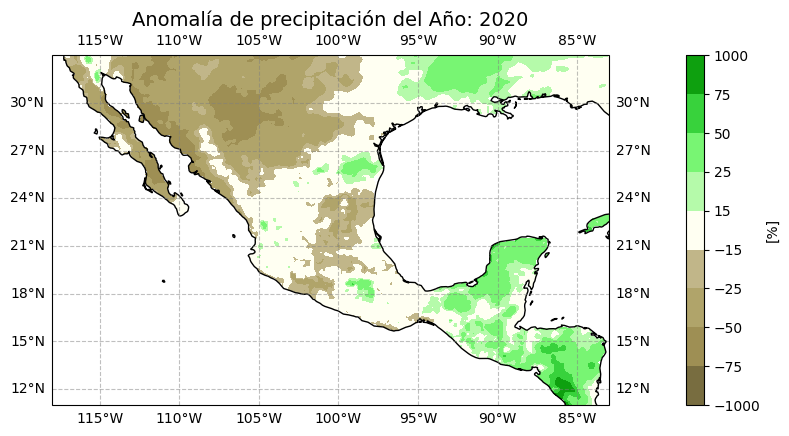

In [12]:
# Muy bien, ahora hagámos una anomalía porcentual

percent = (anom * 100) / base

bounds = [-1000.0, -75.0, -50.0, -25, -15.0, 15.0, 25.0, 50.0, 75.0, 1000.0]
colors = ['#786D40','#9E8F54','#B0A46A','#C1B689','#FFFFF2','#B5FAAA','#78F573','#38D23C','#0EA00F']

# crear la rampa
my_map = mpl.colors.ListedColormap(colors)
norm = mpl.colors.BoundaryNorm(bounds, my_map.N)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(2, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([-118,-83, 11, 33], crs=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels = True, dms = True, x_inline = False, y_inline = False, color = 'gray', alpha = 0.5, linestyle='--')
cs = ax.contourf(lon, lat, percent, levels = bounds, cmap = my_map, norm = norm,  transform=ccrs.PlateCarree())
plt.colorbar(cs, pad = 0.1, label = '[%]')
plt.title('Anomalía de precipitación del Año: 2020', fontsize = 14)


Text(0.5, 1.0, 'Anomalía de precipitación del Año: 2020')

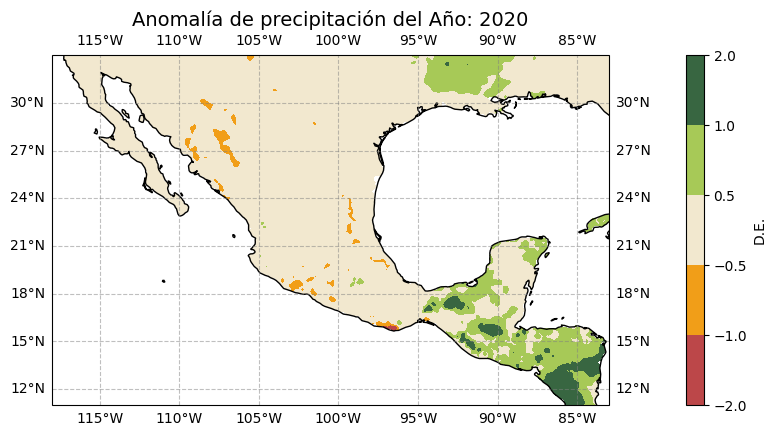

In [13]:
# Y finalmente la anomalía estandarizada

# lo único que nos falta es la desviación estándar y se obtiene exactamente igual

std = np.std(base)

# Y la calculamos
anom_std = (prom_act - base) / std

colors = ['#bc4749','#f19e18','#f2e8cf','#a7c957','#6a994e','#386641']
bounds = [-2.0, -1.0, -0.5, 0.5, 1, 2]

# rampa
my_map = mpl.colors.ListedColormap(colors)
norm = mpl.colors.BoundaryNorm(bounds, my_map.N)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(2, 1, 1, projection=ccrs.PlateCarree())
# Extención del mapa
ax.set_extent([-118,-83, 11, 33], crs=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels = True, dms = True, x_inline = False, y_inline = False, color = 'gray', alpha = 0.5, linestyle='--')
cs = ax.contourf(lon, lat, anom_std, levels = bounds, cmap = my_map, norm = norm,  transform=ccrs.PlateCarree())
plt.colorbar(cs, pad = 0.1, label = 'D.E.')
plt.title('Anomalía de precipitación del Año: 2020', fontsize = 14)

Text(0.5, 1.0, 'Anomalía de precipitación del Año: 2020')

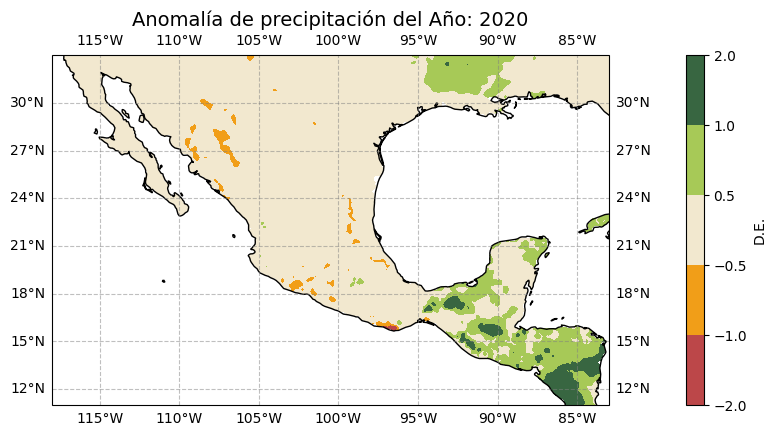

In [14]:
# Y finalmente la anomalía estandarizada
#
# lo único que nos falta es la desviación estándar y se obtiene exactamente igual

std = np.std(base)

# Y la calculamos
anom_std = (prom_act - base) / std


colors = ['#bc4749','#f19e18','#f2e8cf','#a7c957','#6a994e','#386641']
bounds = [-2.0, -1.0, -0.5, 0.5, 1, 2]

# create cmap
my_map = mpl.colors.ListedColormap(colors)
norm = mpl.colors.BoundaryNorm(bounds, my_map.N)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(2, 1, 1, projection=ccrs.PlateCarree())
# Extención del mapa
ax.set_extent([-118,-83, 11, 33], crs=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels = True, dms = True, x_inline = False, y_inline = False, color = 'gray', alpha = 0.5, linestyle='--')
cs = ax.contourf(lon, lat, anom_std, levels = bounds, cmap = my_map, norm = norm,  transform=ccrs.PlateCarree())
plt.colorbar(cs, pad = 0.1, label = 'D.E.')
plt.title('Anomalía de precipitación del Año: 2020', fontsize = 14)


Ahora ¿Cómo sería con xarray?

In [15]:
# Importar librerías
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import netCDF4
from netCDF4 import num2date
import datetime
import matplotlib as mpl

In [16]:
# Abrir los datos
ruta = '/content/Mexico_ppt.nc'
ds = xr.open_dataset(ruta)

# Seleccionar longitud y latitud
lats = ds.latitude
lons = ds.longitude

# Seleccionar la variable
tp = ds['tp']
tp_mm = tp * (30.436875*1000) # convertir los datos

# Vamos a seleccionar el periodo base
tp_base = tp_mm[(tp_mm.time.dt.year > 1990) & (tp_mm.time.dt.year < 2001)]

# Ahora obtengamos el promedio
tp_mean = tp_base.mean('time')

# Ahora vamos a tomar el año 2020
tp_actual_yr = tp_mm[(tp_mm.time.dt.year == 2020)]

# Y ahora el promedio
yr_prom = tp_actual_yr.mean('time')


# Obtenemos la anomalia
anom = yr_prom - tp_mean


# Y listo, sólo queda plotear

Text(0.5, 1.0, 'Anomalía de precipitación del Año: 2020')

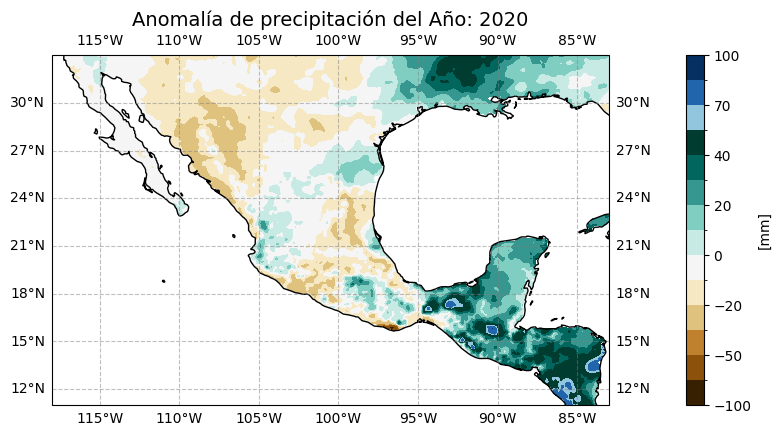

In [17]:
# Limites
bounds = [-100,-80,-50,-40,-20,-10,0,10,20,30,40,60,70,90,100]
colors = ['#372001','#8C510B','#BF812E','#DFC27E','#F6E8C3','#F5F5F5','#C7EAE4','#80CEC1','#369790','#01665E','#003C30','#92C6DE','#2165AC','#063062']

# Rampa
my_map = mpl.colors.ListedColormap(colors)
norm = mpl.colors.BoundaryNorm(bounds, my_map.N)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(2, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([-118,-83, 11, 33], crs=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels = True, dms = True, x_inline = False, y_inline = False, color = 'gray', alpha = 0.5, linestyle='--')
cs = ax.contourf(lons, lats, anom, levels = bounds, cmap = my_map, norm = norm,  transform=ccrs.PlateCarree())
plt.colorbar(cs, pad = 0.1, label = '[mm]')
plt.title('Anomalía de precipitación del Año: 2020', fontsize = 14)

Ahora, supongamos que ahora vamos a usar el periodo de 1991 - 2010 y de ahi, encontrar qué años han sido los más y los menos lluviosos comparado con el periodo base de 1991 - 2000. Vamos paso por paso.

Nota: Yo les recomiendo reiniciar el kernel, para que no se vayan a confundir con variables.

In [29]:
# Abrir los datos
ruta = '/content/Mexico_ppt.nc'
ds = xr.open_dataset(ruta)
ds.variables

Frozen({'longitude': <xarray.IndexVariable 'longitude' (longitude: 351)>
array([-118. , -117.9, -117.8, ...,  -83.2,  -83.1,  -83. ], dtype=float32)
Attributes:
    units:      degrees_east
    long_name:  longitude, 'latitude': <xarray.IndexVariable 'latitude' (latitude: 231)>
array([33. , 32.9, 32.8, ..., 10.2, 10.1, 10. ], dtype=float32)
Attributes:
    units:      degrees_north
    long_name:  latitude, 'time': <xarray.IndexVariable 'time' (time: 396)>
array(['1990-01-01T00:00:00.000000000', '1990-02-01T00:00:00.000000000',
       '1990-03-01T00:00:00.000000000', ..., '2022-10-01T00:00:00.000000000',
       '2022-11-01T00:00:00.000000000', '2022-12-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Attributes:
    long_name:  time, 'tp': <xarray.Variable (time: 396, latitude: 231, longitude: 351)>
[32108076 values with dtype=float32]
Attributes:
    units:      m
    long_name:  Total precipitation})

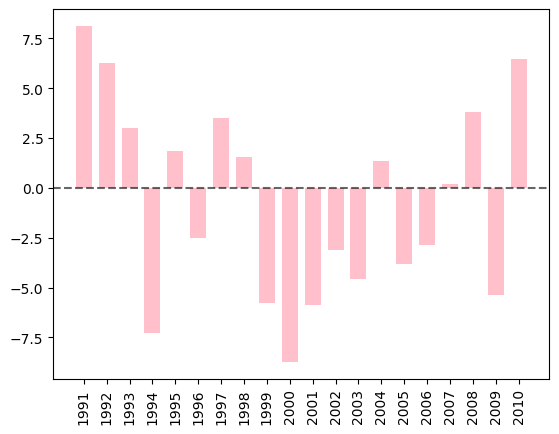

In [18]:
# Podemos hacer una serie de tiempo con los 20 años y ver cómo se comportan
# Empecemos

# Abrir los datos
ruta = '/content/Mexico_ppt.nc'
ds = xr.open_dataset(ruta)

# Seleccionar longitud y latitud
lats = ds.latitude
lons = ds.longitude

# Seleccionar la variable
tp = ds['tp']
tp_mm = tp * (30.436875*1000) # convertir los datos

# Vamos a seleccionar el periodo base
tp_base = tp_mm[(tp_mm.time.dt.year > 1990) & (tp_mm.time.dt.year < 2001)]

# *_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_
# Hasta aquí todo es igual, ahora empiezan a cambiar unas cosas.

# Como queremos hacer una serie de tiempo de cada año entonces primero promediamos en el área
baseline_area = tp_base.mean(['longitude','latitude']) # Esto me da una serie de valores

# Ahora obtenemos el promedio de todos los años
baseline_y_mean = baseline_area.mean('time') # Esto da un valor único


# *_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_
# Ahora hay que obtener el promedio anual de cada año desde 1990 - 2010

# Seleccionar los años
yearly_data = tp_mm[(tp_mm.time.dt.year > 1990) & (tp_mm.time.dt.year < 2011)]

# Ahora obtenemos el promedio en área
yearly_a_mean = yearly_data.mean(['longitude','latitude'])

# Y el promedio por año
year_means = yearly_a_mean.resample(time = '1Y').mean() # Esto nos da un valor por año

# *_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_
# Ahora sí ya podemos obtener la anomalía

anom_10_20 = year_means - baseline_y_mean

# Hagamos unp plot
x = range(1991, 2010 + 1, 1)

fig, ax = plt.subplots()
plt.bar(x, anom_10_20.values, color = 'pink', width = 0.7);
plt.axhline(y = 0, color = 'k', linestyle='--', alpha = 0.6);
plt.xticks(x, rotation = 90);

Y de la misma manera podemos obtener las anomalías estandarizadas.

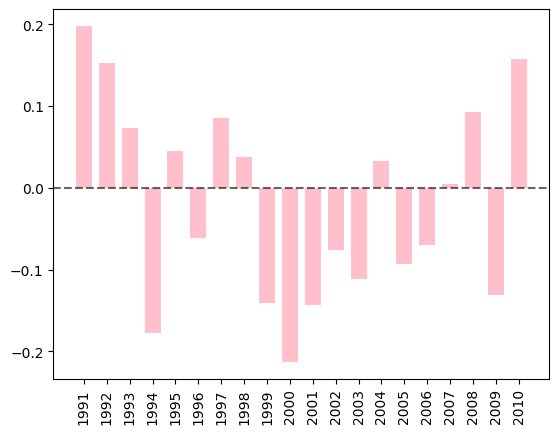

In [19]:
# Vamos a usar el promedio de area de antes: yearly_a_mean
# A esa variable vamos a calcularle su desviación estándar

std_baseline = yearly_a_mean.std('time')

# Y ya con eso podemos obtener la anomalía estandarizada

std_anom = (year_means - baseline_y_mean) / std_baseline

x = range(1991, 2010 + 1, 1)

fig, ax = plt.subplots()
plt.bar(x, std_anom.values, color = 'pink', width = 0.7);
plt.axhline(y = 0, color = 'k', linestyle='--', alpha = 0.6);
plt.xticks(x, rotation = 90);


Si se dan cuenta en teoría ningún año es anormalmente seco o lluvioso ¿Por qué será?

Por eso, aquí les va un ejercicio

In [30]:
ruta = '/content/Temp_1990_2020.nc'
ds = xr.open_dataset(ruta)
ds.variables

Frozen({'longitude': <xarray.IndexVariable 'longitude' (longitude: 401)>
array([110. , 110.1, 110.2, ..., 149.8, 149.9, 150. ], dtype=float32)
Attributes:
    units:      degrees_east
    long_name:  longitude, 'latitude': <xarray.IndexVariable 'latitude' (latitude: 321)>
array([ -8. ,  -8.1,  -8.2, ..., -39.8, -39.9, -40. ], dtype=float32)
Attributes:
    units:      degrees_north
    long_name:  latitude, 'time': <xarray.IndexVariable 'time' (time: 396)>
array(['1990-01-01T00:00:00.000000000', '1990-02-01T00:00:00.000000000',
       '1990-03-01T00:00:00.000000000', ..., '2022-10-01T00:00:00.000000000',
       '2022-11-01T00:00:00.000000000', '2022-12-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Attributes:
    long_name:  time, 't2m': <xarray.Variable (time: 396, latitude: 321, longitude: 401)>
[50973516 values with dtype=float32]
Attributes:
    units:      K
    long_name:  2 metre temperature})

In [52]:
# Podemos hacer una serie de tiempo con los 20 años y ver cómo se comportan
# Empecemos

# Abrir los datos
ruta = '/content/Temp_1990_2020.nc'
ds = xr.open_dataset(ruta)

# Seleccionar longitud y latitud
lats = ds.latitude
lons = ds.longitude

# Seleccionar la variable
tp = ds['t2m']
tp_mm = tp - 273.15 # convertir los datos

# Vamos a seleccionar el periodo base
tp_base = tp_mm[(tp_mm.time.dt.year > 1990) & (tp_mm.time.dt.year < 2010)]
tp_base2 = tp_base[tp_base.time.dt.month == 12]

# *_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_
# Hasta aquí todo es igual, ahora empiezan a cambiar unas cosas.

# Como queremos hacer una serie de tiempo de cada año entonces primero promediamos en el área
baseline_area = tp_base2.mean(['longitude','latitude']) # Esto me da una serie de valores

# Ahora obtenemos el promedio de todos los años
baseline_y_mean = baseline_area.mean('time') # Esto da un valor único


# *_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_
# Ahora hay que obtener el promedio anual de cada año desde 1990 - 2010

# Seleccionar los
yearly_data = tp_mm[(tp_mm.time.dt.year > 1990) & (tp_mm.time.dt.year < 2022)]
yearly_data2 = yearly_data[yearly_data.time.dt.month == 12]

# Ahora obtenemos el promedio en área
yearly_a_mean = yearly_data2.mean(['longitude','latitude'])

# Y el promedio por año
#year_means = yearly_a_mean.resample(time = '1Y').mean() # Esto nos da un valor por año

# *_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_*_
# Ahora sí ya podemos obtener la anomalía

anom_10_20 = yearly_a_mean - baseline_y_mean

# Hagamos unp plot
x = range(1991, 2021 + 1, 1)

fig, ax = plt.subplots()
plt.bar(x, anom_10_20.values, color = 'pink', width = 0.7);
plt.axhline(y = 0, color = 'k', linestyle='--', alpha = 0.6);
plt.xticks(x, rotation = 90);

max = tp_base2.max()
max
min = tp_base2.min()
min

<xarray.DataArray 't2m' ()>
array(36.152466, dtype=float32)

In [60]:
np.where(anom_10_20 >=3) #28
np.where(anom_10_20 <=2) #8

anom_10_20[28] #2019
anom_10_20[8] #1999

<xarray.DataArray 't2m' ()>
array(-1.6142483, dtype=float32)
Coordinates:
    time     datetime64[ns] 1999-12-01

TypeError: Length of x (2) must match number of columns in z (351)

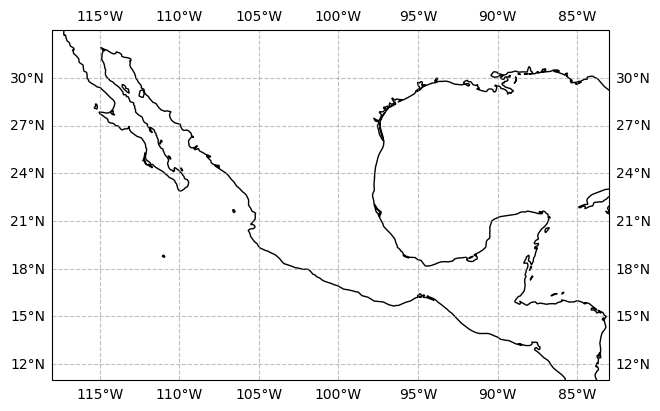

In [63]:
lons= [9, 44]
lons
lats= [113, 154]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(2, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([-118,-83, 11, 33], crs=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels = True, dms = True, x_inline = False, y_inline = False, color = 'gray', alpha = 0.5, linestyle='--')
cs = ax.contourf(lons, lats, anom, levels = np.arange(np.min(anom), np.max(anom), 10), cmap = 'RdBu', transform=ccrs.PlateCarree())
plt.colorbar(cs, pad = 0.1, label = '[mm]')
plt.title('Anomalía de precipitación del Año: 2020', fontsize = 14)